# Colour Correction using Splines

### Define constants

In [92]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_illuminant_cmfs, load_camera
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset
CAMERA = 'nikon'

### Spectral sensitivities of various cameras

In [94]:

MSDS_TRAIN, SDS_TRAIN = load_camera(CAMERA)


### Computing Observer Responses
We can easily change the order of test and train sets here

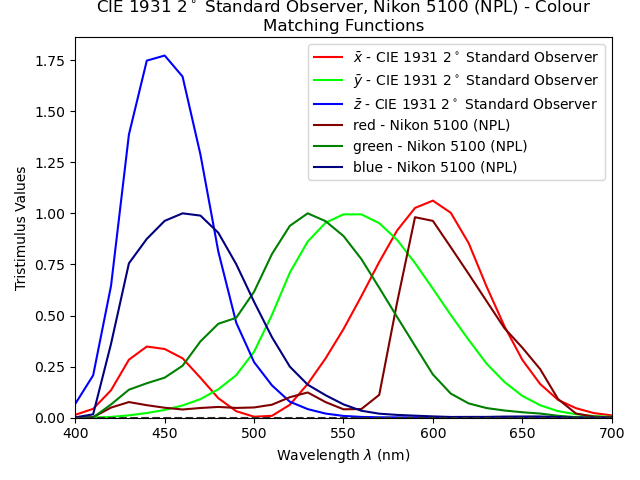

In [95]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([MSDS_TRAIN, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant)

### Chromaticity Diagrams

C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


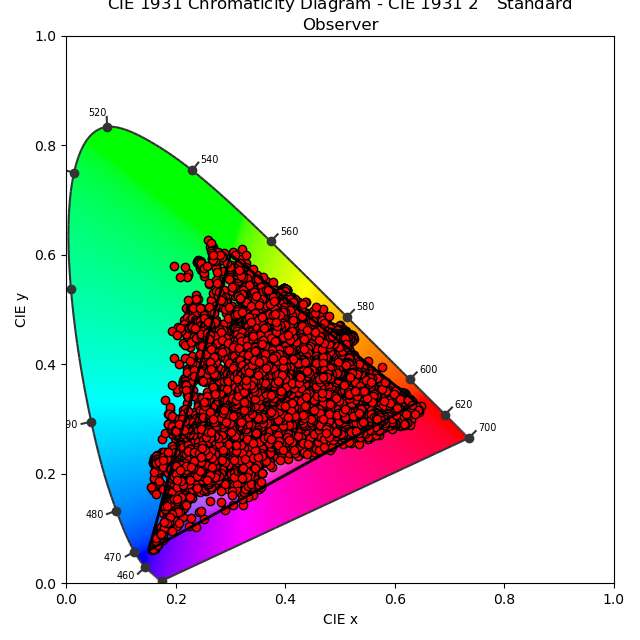

C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


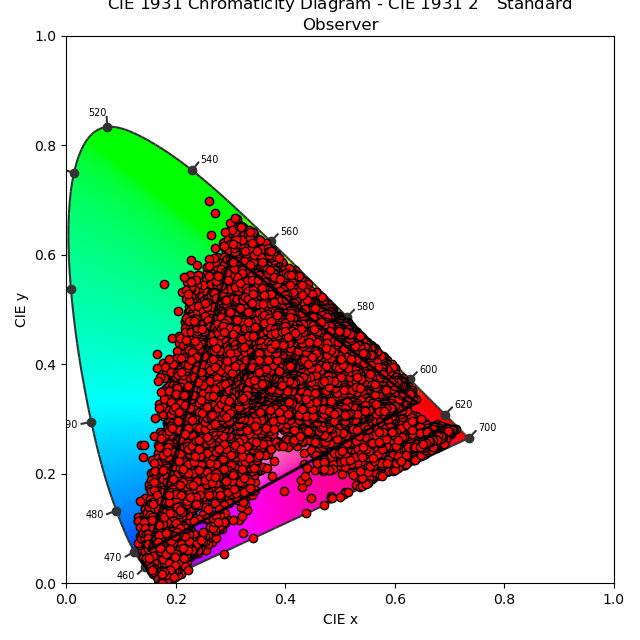

C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


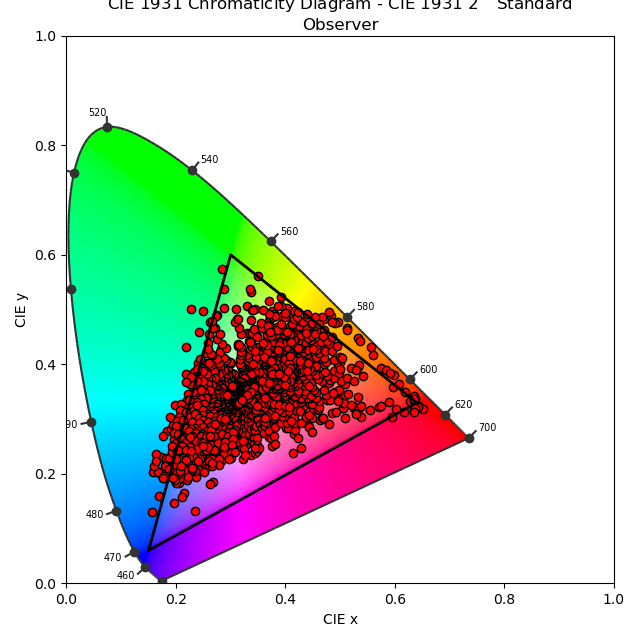

In [96]:
from plotting import plot_chromaticity_diagram
plot_chromaticity_diagram(response_trainset_xyz)
plot_chromaticity_diagram(response_testset_xyz)
plot_chromaticity_diagram(response_validation_xyz)

### Computing Camera Responses

In [97]:
response_trainset_camera, _ = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_camera, _ = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)
response_validationset_camera,  _ = colour.characterisation.training_data_sds_to_RGB(VALIDATION, MSDS_TRAIN, SDS_TRAIN)

print(np.max(response_trainset_camera))
print(np.max(response_testset_camera))
print(np.max(response_validationset_camera))

1.12316386532
1.12363282681
1.02033351933


In [98]:
response_trainset_camera_augmented = np.vstack((response_trainset_camera, response_trainset_camera / 2))
response_trainset_xyz_augmented = np.vstack((response_trainset_xyz, response_trainset_xyz / 2))


### Fit Generalized Additive Model with P-splines

In [41]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
# gam5 = GAMOptimizer(lams=1e-9, order=3, n_splines=5)
# gam10 = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
gam = GAMOptimizer(lams=0.01,order=3, n_splines=20)

gam.fit(response_trainset_camera, response_trainset_xyz)

pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

KeyboardInterrupt: 

(100, 100)
0.954630242109
-0.100548880715


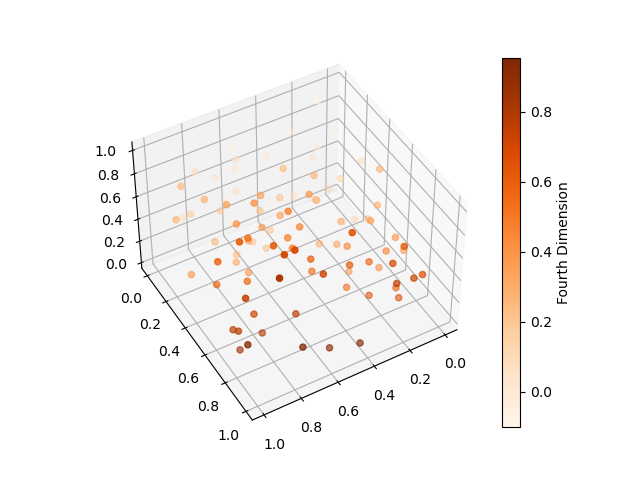

In [100]:
gam.plot_4d()

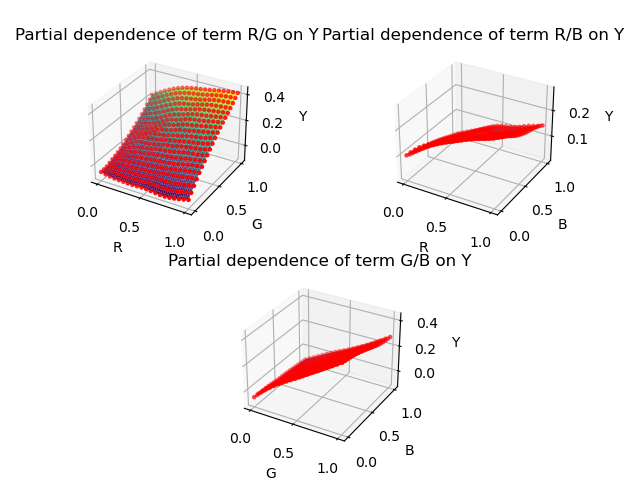

In [101]:
%matplotlib ipympl

gam.plot_partial_dependences_for_Y()

### Fit Linear Model

In [114]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False)


linear.fit(response_trainset_camera, response_trainset_xyz)
pred(linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(linear, response_testset_camera, response_testset_xyz, "DeltaE SFU")

ValueError: y should be a 1d array, got an array of shape (39935, 3) instead.

### Fit 3rd order Root-Polynomial Model

In [103]:
from models import PolynomialTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])

RP_linear_3.fit(response_trainset_camera, response_trainset_xyz)

pred(RP_linear_3, response_testset_camera  / 4, response_testset_xyz / 4, "DeltaE SFU")
pred(RP_linear_3, response_testset_camera  / 3, response_testset_xyz / 3, "DeltaE SFU")
pred(RP_linear_3, response_testset_camera  / 2, response_testset_xyz / 2, "DeltaE SFU")

---- RESULTS DeltaE SFU ----
DeltaE mean: 1.0505296592870348
DeltaE max: 5.505709343538653
DeltaE min: 0.005250136878515609
DeltaE median: 0.8350189680381885
DeltaE 95 percentile: 2.4199882613212043
DeltaE 99 percentile: 2.962053368300579
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.0505296592870002
DeltaE max: 5.5057093435387445
DeltaE min: 0.005250136878596119
DeltaE median: 0.835018968037975
DeltaE 95 percentile: 2.4199882613198587
DeltaE 99 percentile: 2.962053368300234
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.0505296592869613
DeltaE max: 5.505709343538653
DeltaE min: 0.005250136878562612
DeltaE median: 0.8350189680376305
DeltaE 95 percentile: 2.4199882613212043
DeltaE 99 percentile: 2.9620533683009644


### Fit a 2nd order Root-Polynomial Model

In [104]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_2 = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])


RP_linear_2.fit(response_trainset_camera, response_trainset_xyz)
pred(RP_linear_2, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(RP_linear_2, response_testset_camera / 2, response_testset_xyz / 2, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.0441762517659028
DeltaE max: 5.370639254011571
DeltaE min: 0.004646918405558664
DeltaE median: 0.8241686972871005
DeltaE 95 percentile: 2.419106008230185
DeltaE 99 percentile: 3.0184799082264266
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.0441762517659028
DeltaE max: 5.370639254011571
DeltaE min: 0.004646918405558664
DeltaE median: 0.8241686972871005
DeltaE 95 percentile: 2.419106008230185
DeltaE 99 percentile: 3.0184799082264266


In [105]:
P_Linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_Linear_3.fit(response_trainset_camera, response_trainset_xyz)
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.0609971284940602
DeltaE max: 5.2284645187339835
DeltaE min: 0.0020041875630129693
DeltaE median: 0.8859730092040334
DeltaE 95 percentile: 2.353784318176778
DeltaE 99 percentile: 2.9496238415608396
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.0609971284940602
DeltaE max: 5.2284645187339835
DeltaE min: 0.0020041875630129693
DeltaE median: 0.8859730092040334
DeltaE 95 percentile: 2.353784318176778
DeltaE 99 percentile: 2.9496238415608396


In [106]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_linear.fit(response_trainset_camera, response_trainset_xyz)
pred(P_linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(P_linear, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.1242471221969972
DeltaE max: 5.396037689070847
DeltaE min: 0.003833464679956052
DeltaE median: 0.9724997376175623
DeltaE 95 percentile: 2.406754004533125
DeltaE 99 percentile: 3.014407185037334
---- RESULTS DeltaE SFU ----
DeltaE mean: 0.8889719331814939
DeltaE max: 4.656550967837816
DeltaE min: 0.036714113467617555
DeltaE median: 0.6401073797245199
DeltaE 95 percentile: 2.5466116156116843
DeltaE 99 percentile: 3.614595177596601



DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=True, degree=3))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

In [107]:

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


#DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
#pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
#pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

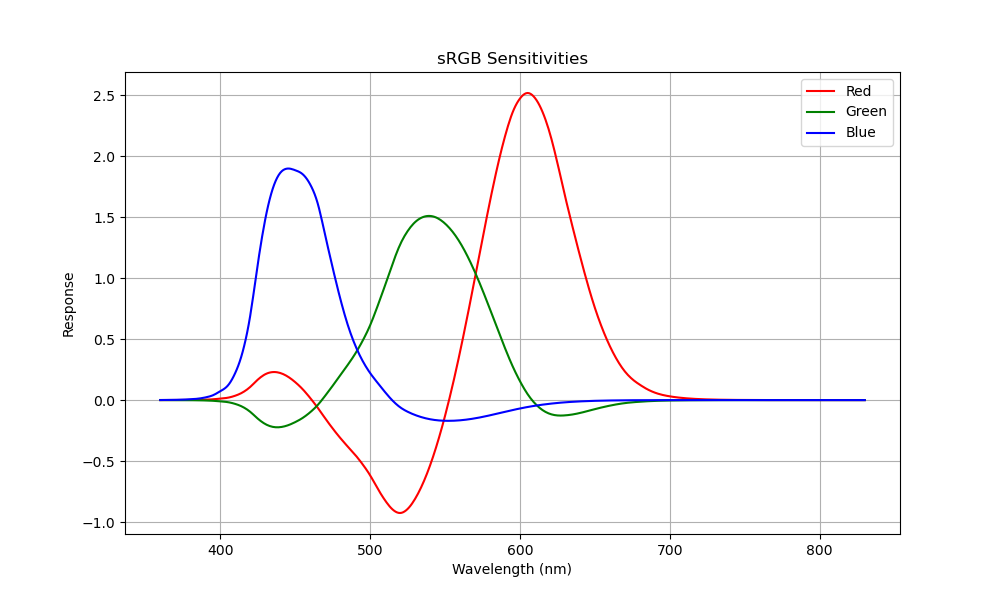

In [108]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)


In [109]:
from models import GAMOptimizer
from evaluate import pred
from sklearn.pipeline import Pipeline
from models import PolynomialTransformer
from sklearn.linear_model import LinearRegression
from colour import SpectralShape
from colour import MSDS_CAMERA_SENSITIVITIES, MSDS_CMFS
import numpy as np
#spectra = Pipeline([
#    ('transformer', PolynomialTransformer(degree=3, rp=False)),
#    ('regressor', LinearRegression(fit_intercept=False))
# ])

spectra = GAMOptimizer(lams=1e-3, order=3, n_splines=20)


cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy()
MSDS_TRAIN = MSDS_CAMERA_SENSITIVITIES['Nikon 5100 (NPL)']
cmfs.values = cmfs.values / np.max(cmfs.values)
source = MSDS_TRAIN.align(SpectralShape(400, 700, 1)).values
target = cmfs.align(SpectralShape(400, 700, 1)).values
print(MSDS_TRAIN.wavelengths)
spectra.fit(source, target)

[ 400.  401.  402.  403.  404.  405.  406.  407.  408.  409.  410.  411.
  412.  413.  414.  415.  416.  417.  418.  419.  420.  421.  422.  423.
  424.  425.  426.  427.  428.  429.  430.  431.  432.  433.  434.  435.
  436.  437.  438.  439.  440.  441.  442.  443.  444.  445.  446.  447.
  448.  449.  450.  451.  452.  453.  454.  455.  456.  457.  458.  459.
  460.  461.  462.  463.  464.  465.  466.  467.  468.  469.  470.  471.
  472.  473.  474.  475.  476.  477.  478.  479.  480.  481.  482.  483.
  484.  485.  486.  487.  488.  489.  490.  491.  492.  493.  494.  495.
  496.  497.  498.  499.  500.  501.  502.  503.  504.  505.  506.  507.
  508.  509.  510.  511.  512.  513.  514.  515.  516.  517.  518.  519.
  520.  521.  522.  523.  524.  525.  526.  527.  528.  529.  530.  531.
  532.  533.  534.  535.  536.  537.  538.  539.  540.  541.  542.  543.
  544.  545.  546.  547.  548.  549.  550.  551.  552.  553.  554.  555.
  556.  557.  558.  559.  560.  561.  562.  563.  5

GAMOptimizer(lams=0.001, n_splines=20, order=3)

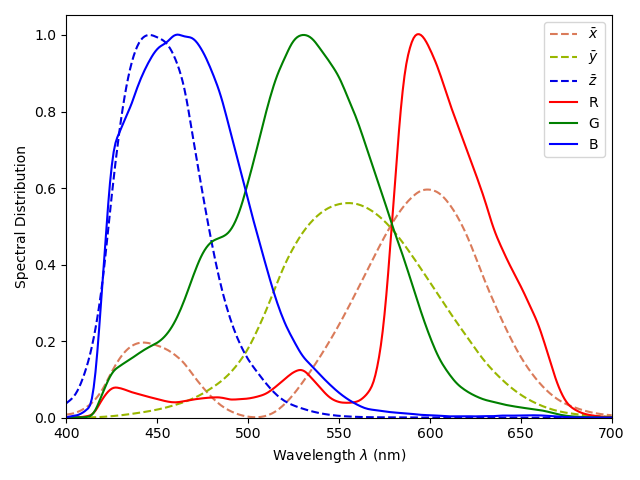

In [110]:
from colour.plotting import plot_multi_sds
from colour import MultiSpectralDistributions
import matplotlib.pyplot as plt
out = spectra.predict(MSDS_TRAIN.values)
out[out<0] = 0
out_spectra = MultiSpectralDistributions(out, SpectralShape(400, 700, 1))
plot_kwargs = [
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},

    {"use_sd_colours": False, "linestyle": "solid", "color": "red", "label": "R"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "green", "label": "G"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "blue", "label": "B"},
]
fig, ax = plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False)
plt.subplots_adjust(top=0.85)

plt.title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")
plt.savefig("spectralsensitivities.png", transparent=False)

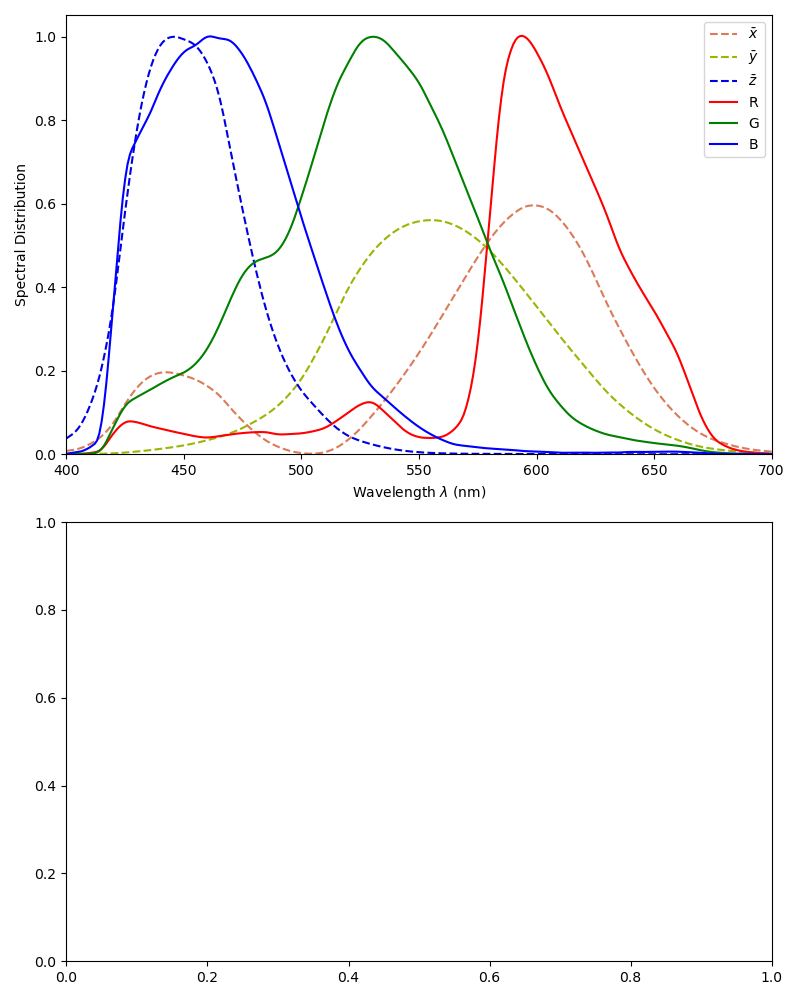

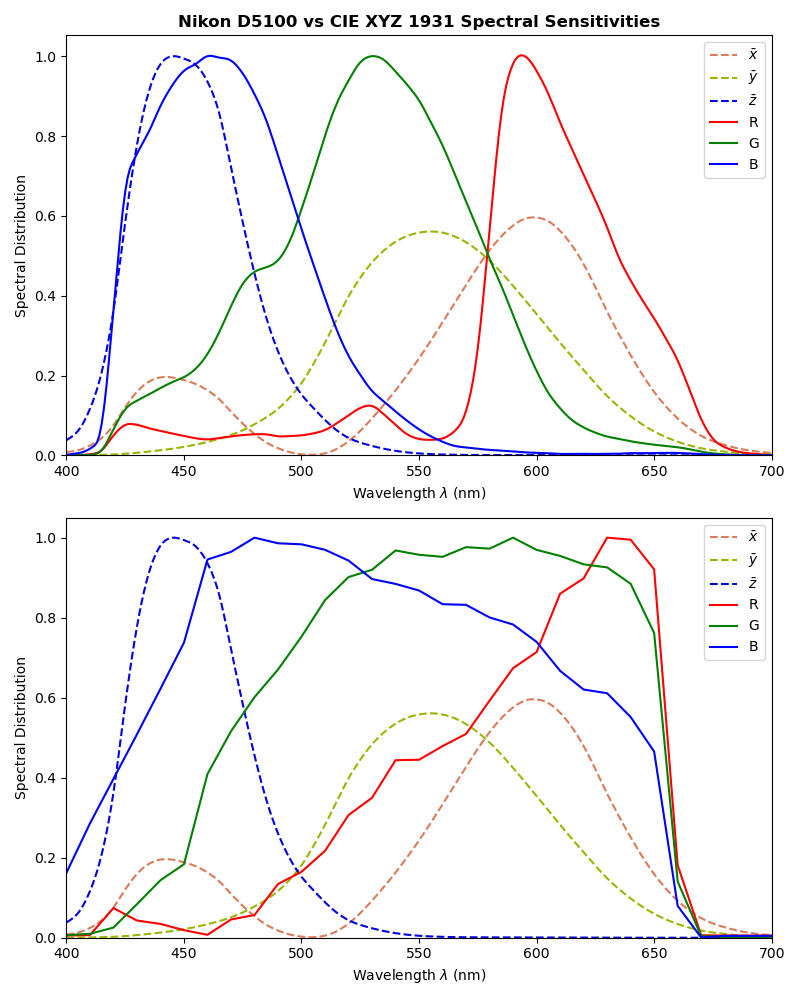

In [111]:
# Your original plotting code here, modified to include subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Creates 2 rows and 1 column of subplots

# Plot the first set of data on the first subplot
plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[0])
axs[0].set_title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")


MSDS_TEST, SDS_TEST = load_camera('sigma')
# Plot the second set of data on the second subplot
plot_multi_sds([cmfs, MSDS_TEST], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[1])
axs[1].set_title("Sigma SDMerill vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")

# Adjust the layout so that titles and labels don't overlap
plt.tight_layout()

# Save the figure
plt.savefig("spectralsensitivities_subplot.png", transparent=False)

In [112]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cave_foster2004_dataset.values.T)
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.986817136812
[ 0.82520032  0.12043595  0.0322493   0.00893157]
